## Testing parallel Processing of the Stochastic Paths

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # <--- The secret weapon
import time
from numba import njit, prange

# --- 1. Simulation Setup (Using the Numba fast method) ---
D_t = 0.0
D_r = 0.01
sigma = 0.001
beta = 100
lamda = 0.6
alpha = 0.1
v0 = 0.01
t0 = 0.0
tn = 3000
dt = 0.1
num_paths = 1000 
init_x, init_z, init_phi = 0.0, -2.0, -0.5 * np.pi

t_array = np.arange(t0, tn + 1e-6, dt)
N = len(t_array)

@njit(parallel=True, fastmath=True)
def run_simulation_numba(num_paths, N, t_array, dt, D_r, lamda, alpha, sigma, beta, v0):
    all_x = np.zeros((num_paths, N), dtype=np.float64)
    all_z = np.zeros((num_paths, N), dtype=np.float64)
    all_phi = np.zeros((num_paths, N), dtype=np.float64)
    path_lengths = np.full(num_paths, N, dtype=np.int64)
    sqrt_dt_noise = np.sqrt(2 * D_r * dt)

    for p in prange(num_paths):
        curr_x, curr_z, curr_phi = init_x, init_z, init_phi
        all_x[p, 0], all_z[p, 0], all_phi[p, 0] = curr_x, curr_z, curr_phi
        
        for i in range(N - 1):
            exp_z = np.exp(curr_z)
            phase_diff = curr_x - t_array[i]
            noise = sqrt_dt_noise * np.random.standard_normal()
            
            next_phi = curr_phi + (lamda*alpha*exp_z*np.cos(phase_diff + 2*curr_phi) + 0.5*sigma*(1 + lamda*np.cos(2*curr_phi)))*dt + noise
            next_x = curr_x + (alpha*exp_z*np.cos(phase_diff) + v0*np.sin(curr_phi) + sigma *(beta + curr_z))*dt
            next_z = curr_z + (alpha*exp_z*np.sin(phase_diff) + v0*np.cos(curr_phi))*dt
            
            all_x[p, i+1], all_z[p, i+1], all_phi[p, i+1] = next_x, next_z, next_phi
            curr_x, curr_z, curr_phi = next_x, next_z, next_phi
            
            if curr_z > 0:
                path_lengths[p] = i + 2
                break
    return all_x, all_z, all_phi, path_lengths

# Run Simulation
print("Running simulation...")
raw_x, raw_z, raw_phi, lengths = run_simulation_numba(num_paths, N, t_array, dt, D_r, lamda, alpha, sigma, beta, v0)

# Process Data for plotting
# We need a list of (N, 2) arrays for LineCollection
segments_real = []
segments_phase = []

for i in range(num_paths):
    L = lengths[i]
    # Real Space Segments (x vs z)
    segments_real.append(np.column_stack((raw_x[i, :L], raw_z[i, :L])))
    
    # Phase Space processing
    phi_curr = raw_phi[i, :L]
    phip = np.mod(phi_curr, 2*np.pi)
    phipp = np.where(phip >= np.pi, phip - 2*np.pi, phip)
    
    # Note: LineCollection will draw lines connecting the jump from pi to -pi.
    # To fix this perfectly requires splitting lines, but for speed, we plot as is
    # or consider a scatter plot/2d histogram for phase space.
    segments_phase.append(np.column_stack((phipp, raw_z[i, :L])))

Running simulation...


In [11]:
plot = False
if plot == True:
    # --- 2. FAST Plotting with LineCollection ---
    print("Plotting...")
    t_plot_start = time.time()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # --- Plot 1: Phase Space ---
    # Create Collection
    lc_phase = LineCollection(segments_phase, linewidths=0.5, colors='blue', alpha=0.1)
    ax1.add_collection(lc_phase)
    ax1.autoscale() # Essential because add_collection doesn't auto-update limits
    ax1.set_xlabel('$\phi$')
    ax1.set_ylabel('z')
    ax1.set_title('Phase Space')
    ax1.grid(True)

    # --- Plot 2: Real Space ---
    # Create Collection
    lc_real = LineCollection(segments_real, linewidths=0.5, colors='blue', alpha=0.1)
    ax2.add_collection(lc_real)
    ax2.autoscale()
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    ax2.set_title('Real Space')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    print(f"Plotting finished in {time.time() - t_plot_start:.4f} seconds.")


<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_45583/1522006139.py:14: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_xlabel('$\phi$')


In [12]:
import gc # Garbage collector interface

print("Converting raw data to 'paths' list...")

# 1. Create the list structure your average function expects
paths = []
for i in range(num_paths):
    L = lengths[i]
    # Slice only the valid data (up to L) to save space
    p_x = raw_x[i, :L]
    p_z = raw_z[i, :L]
    p_phi = raw_phi[i, :L]
    paths.append((p_x, p_z, p_phi))

print(f"Created {len(paths)} paths.")

# 2. CRITICAL: Free up the massive Numba arrays to prevent Kernel Death
# We don't need these anymore since the data is now in 'paths'
del raw_x
del raw_z
del raw_phi
del segments_real
del segments_phase

# Force Python to release the memory now
gc.collect() 
print("Memory cleaned. Ready for averaging.")

Converting raw data to 'paths' list...
Created 1000 paths.
Memory cleaned. Ready for averaging.


In [13]:
def average(paths, t):
    """
    Averages paths that survived the full duration 't'.
    Prints statistics on how many paths are used.
    """
    total_paths = len(paths)
    target_length = len(t)
    
    vpaths = []

    # Filter: Keep only paths that match the target time length exactly
    for x, z, phi in paths:
        if len(z) == target_length:
            vpaths.append((x, z, phi))

    # --- REPORTING ---
    considered = len(vpaths)
    percentage = (considered / total_paths) * 100
    
    print("-" * 40)
    print(f"AVERAGING STATISTICS")
    print("-" * 40)
    print(f"Total Paths Simulated: {total_paths}")
    print(f"Paths Considered:      {considered}")
    print(f"Paths Discarded:       {total_paths - considered} (died early or length mismatch)")
    print(f"Utilization Rate:      {percentage:.2f}%")
    print("-" * 40)
    
    if considered == 0:
        print("❌ ERROR: No paths survived the full duration!")
        print("   Cannot compute average. Returning empty arrays.")
        print("   Tip: Check if your particle boundaries (z>0) are too aggressive.")
        return np.array([]), np.array([]), np.array([])

    # Average Calculation
    xx, zz, pphi = [], [], []

    for x, z, phi in vpaths:
        xx.append(x)
        zz.append(z)
        pphi.append(phi)

    xx = np.array(xx)
    zz = np.array(zz)
    pphi = np.array(pphi)

    return xx.mean(axis=0), zz.mean(axis=0), pphi.mean(axis=0)


----------------------------------------
AVERAGING STATISTICS
----------------------------------------
Total Paths Simulated: 1000
Paths Considered:      395
Paths Discarded:       605 (died early or length mismatch)
Utilization Rate:      39.50%
----------------------------------------


<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_45583/664204651.py:12: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_xlabel('$\phi$')


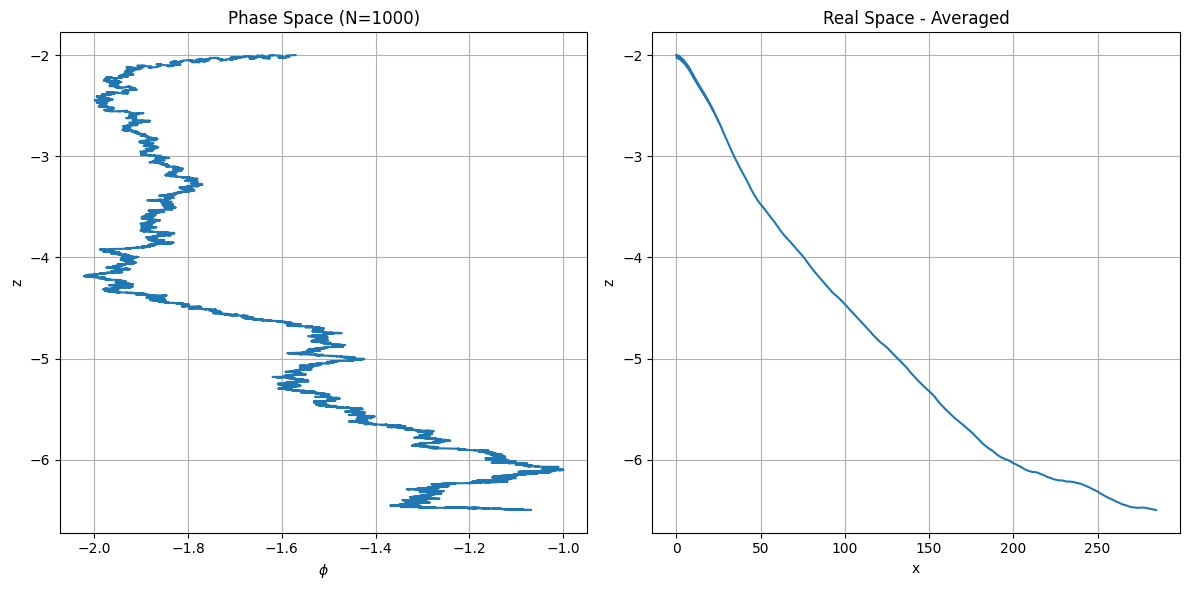

In [ ]:
# --- Usage ---
# Ensure t is the same time array used for the plot/simulation
# For example: t_plot = np.arange(len(paths[0][0])) * dt 

xm, zm, phim = average(paths, t_array) 

# Only plot if we actually got data back
if len(xm) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(phim, zm)
    ax1.set_xlabel('$\phi$')
    ax1.set_ylabel('z')
    ax1.set_title(f'Phase Space (N={len(paths)})')
    ax1.grid()

    ax2.plot(xm, zm)
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    ax2.set_title('Real Space - Averaged')
    ax2.grid()

    plt.tight_layout() 
    plt.savefig('longMS_average1.png', dpi=300)
    plt.show()